<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/simulation/FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python で有限要素法

## FEM from scratch

変数と import をクリア

In [1]:
%reset -f

[KdV 方程式を解く](http://www.cas.cmc.osaka-u.ac.jp/~paoon/Lectures/2018-7Semester-AppliedMath9/14_pde-fem/)

### 係数行列の定義

In [2]:
dx, L = 0.01, 2
N = int(L / dx)

dt = 0.0001

In [3]:
import numpy as np
from scipy.sparse import dia_array

ex = np.ones(N)
diagonals = np.array([
    1/6 * ex, 1/6 * ex, 2/3 * ex, 1/6 * ex, 1/6 * ex
])
offsets = np.array([-(N-1), -1, 0, 1, (N-1)])

phi = dia_array((diagonals, offsets), shape=(N, N)) * dx

In [4]:
type(phi)

scipy.sparse._csr.csr_array

In [5]:
# 行列の端をどれくらい表示するか
np.set_printoptions(edgeitems=3)
# 桁数をどうするか
np.set_printoptions(precision=3)

# np.ndarray で表示
phi.toarray()

array([[0.007, 0.002, 0.   , ..., 0.   , 0.   , 0.002],
       [0.002, 0.007, 0.002, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.002, 0.007, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.007, 0.002, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.002, 0.007, 0.002],
       [0.002, 0.   , 0.   , ..., 0.   , 0.002, 0.007]])

In [6]:
ex = np.ones(N)
diagonals = np.array([
    -1/2 * ex, 1/2 * ex, -1/2 * ex, 1/2 * ex
])
offsets = np.array([-(N-1), -1, 1, (N-1)])

d1 = dia_array((diagonals, offsets), shape=(N, N))

d1.toarray()

array([[ 0. , -0.5,  0. , ...,  0. ,  0. ,  0.5],
       [ 0.5,  0. , -0.5, ...,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. , -0.5,  0. ],
       [ 0. ,  0. ,  0. , ...,  0.5,  0. , -0.5],
       [-0.5,  0. ,  0. , ...,  0. ,  0.5,  0. ]])

In [7]:
ex = np.ones(N)
diagonals = np.array([
    -1 * ex, -1 * ex, 2 * ex, -1 * ex, -1 * ex
])
offsets = np.array([-(N-1), -1, 0, 1, (N-1)])

d2 = dia_array((diagonals, offsets), shape=(N, N)) / dx

d2.toarray()

array([[ 200., -100.,    0., ...,    0.,    0., -100.],
       [-100.,  200., -100., ...,    0.,    0.,    0.],
       [   0., -100.,  200., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,  200., -100.,    0.],
       [   0.,    0.,    0., ..., -100.,  200., -100.],
       [-100.,    0.,    0., ...,    0., -100.,  200.]])

In [8]:
def p_func(u: np.ndarray) -> np.ndarray:
    u_plus = np.roll(u, -1)
    u_minus = np.roll(u, 1)
    result = (u_plus + u + u_minus) * (u_plus - u_minus) / 6
    return result

p_func(np.array([1, 2, 3]))

array([-1.,  2., -1.])

### ソルバーを定義

In [9]:
from scipy.sparse.linalg import bicg

epsilon = 0.022

def dudt(u: np.ndarray) -> np.ndarray:
    x, _ = bicg(phi, u @ d2, atol=1e-5)
    x = p_func(u) + epsilon ** 2 * x @ d1
    x, _ = bicg(-phi, x, atol=1e-5)
    return x

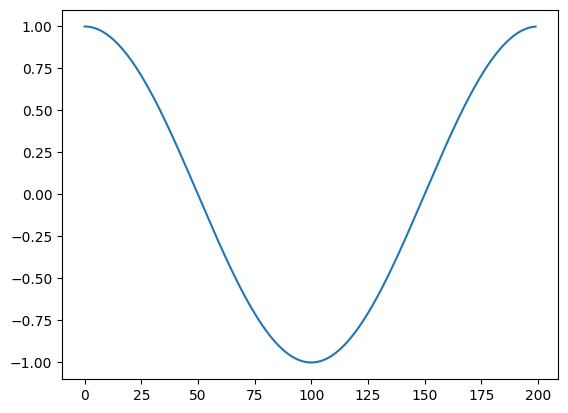

In [10]:
import matplotlib.pyplot as plt

u0 = np.array([np.cos(k * np.pi * dx) for k in range(N)])

plt.plot(range(N), u0)

In [11]:
def rk4(u: np.ndarray, dt: float) -> np.ndarray:
    k1 = dt * dudt(u)
    k2 = dt * dudt(u + k1 / 2)
    k3 = dt * dudt(u + k2 / 2)
    k4 = dt * dudt(u + k3)
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [12]:
from tqdm.notebook import tqdm

u, u_list = u0, [u0]
save_interval, max_iter = 1000, 10000
for idx in tqdm(range(max_iter)):
    u = rk4(u, dt)
    if idx % save_interval == 0:
        u_list.append(u)

  0%|          | 0/10000 [00:00<?, ?it/s]

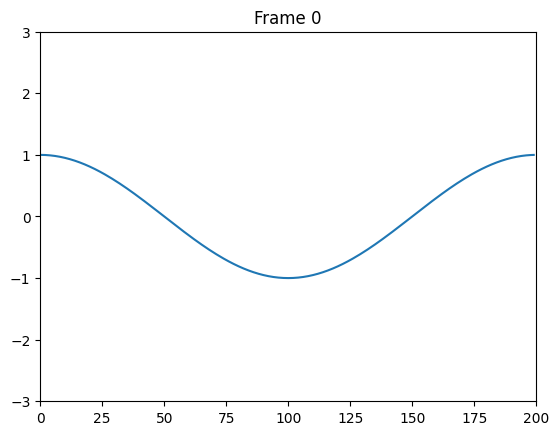

In [13]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

ax.set_xlim(0, N)
ax.set_ylim(-3, 3)

sol_plt, = ax.plot([], [], label="solution")

def anim_callback(i):
    ax.set_title(f"Frame {i}")
    sol_plt.set_data(range(N), u_list[i])

ani = animation.FuncAnimation(
    fig, anim_callback, frames=int(max_iter/save_interval))
ani.save("kdv.gif", writer="pillow")

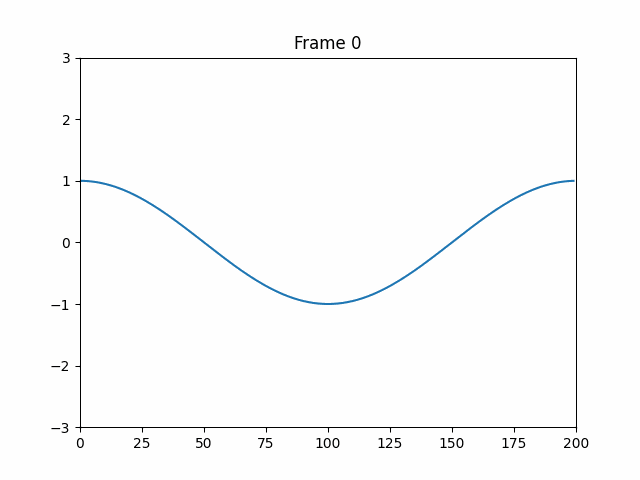

In [14]:
import IPython
from IPython.display import Image

Image("./kdv.gif", format='png')

## SfePy

変数と import をクリア

In [1]:
%reset -f

In [3]:
%%capture
pip install sfepy

In [4]:
!wget https://github.com/sfepy/sfepy/raw/master/meshes/2d/rectangle_tri.mesh

--2024-07-12 15:03:58--  https://github.com/sfepy/sfepy/raw/master/meshes/2d/rectangle_tri.mesh
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sfepy/sfepy/master/meshes/2d/rectangle_tri.mesh [following]
--2024-07-12 15:03:58--  https://raw.githubusercontent.com/sfepy/sfepy/master/meshes/2d/rectangle_tri.mesh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15526 (15K) [text/plain]
Saving to: ‘rectangle_tri.mesh’

rectangle_tri.mesh  100%[===================>]  15.16K  --.-KB/s    in 0s      

2024-07-12 15:03:58 (74.9 MB/s) - ‘rectangle_tri.mesh’ saved [15526/15526]



In [5]:
from sfepy.discrete.fem import Mesh, FEDomain

mesh = Mesh.from_file("/content/rectangle_tri.mesh")
domain = FEDomain('domain', mesh)

sfepy: reading mesh (/content/rectangle_tri.mesh)...
sfepy:   number of vertices: 258
sfepy:   number of cells:
sfepy:     2_3: 454
sfepy: ...done in 0.01 s


In [6]:
min_x, max_x = domain.get_mesh_bounding_box()[:,0]
eps = 1e-8 * (max_x - min_x)
omega = domain.create_region('Omega', 'all')
gamma1 = domain.create_region('Gamma1',
                                'vertices in x < %.10f' % (min_x + eps),
                                'facet')
gamma2 = domain.create_region('Gamma2',
                                'vertices in x > %.10f' % (max_x - eps),
                                'facet')

In [9]:
import numpy as np
from sfepy.discrete.fem import Field

field = Field.from_args('fu', np.float64, 'vector', omega,
                        approx_order=2)

In [10]:
from sfepy.discrete import FieldVariable, Material, Integral
from sfepy.mechanics.matcoefs import stiffness_from_lame

u = FieldVariable('u', 'unknown', field)
v = FieldVariable('v', 'test', field, primary_var_name='u')

m = Material('m', D=stiffness_from_lame(dim=2, lam=1.0, mu=1.0))
f = Material('f', val=[[0.02], [0.01]])

integral = Integral('i', order=3)

In [11]:
from sfepy.terms import Term
from sfepy.discrete import Equation, Equations

t1 = Term.new('dw_lin_elastic(m.D, v, u)',
                integral, omega, m=m, v=v, u=u)
t2 = Term.new('dw_volume_lvf(f.val, v)', integral, omega, f=f, v=v)
eq = Equation('balance', t1 + t2)
eqs = Equations([eq])

In [12]:
def shift_u_fun(ts, coors, bc=None, problem=None, shift=0.0):
    """
    Define a displacement depending on the y coordinate.
    """
    val = shift * coors[:,1]**2

    return val

In [17]:
from sfepy.discrete import Function
from sfepy.discrete.conditions import EssentialBC
from sfepy.solvers.ls import ScipyDirect
from sfepy.base.base import IndexedStruct
from sfepy.solvers.nls import Newton

fix_u = EssentialBC('fix_u', gamma1, {'u.all' : 0.0})

bc_fun = Function('shift_u_fun', shift_u_fun,
                    extra_args={'shift' : 0.01})
shift_u = EssentialBC('shift_u', gamma2, {'u.0' : bc_fun})

ls = ScipyDirect({})

nls_status = IndexedStruct()
nls = Newton({}, lin_solver=ls, status=nls_status)

In [18]:
from sfepy.discrete import Problem
from sfepy.discrete.conditions import Conditions

pb = Problem('elasticity', equations=eqs)
pb.save_regions_as_groups('regions')

pb.set_bcs(ebcs=Conditions([fix_u, shift_u]))

pb.set_solver(nls)

status = IndexedStruct()
variables = pb.solve(status=status)

print('Nonlinear solver status:\n', nls_status)
print('Stationary solver status:\n', status)

pb.save_state('linear_elasticity.vtk', variables)

sfepy: saving regions as groups...
sfepy:   Omega
sfepy:   Gamma1
sfepy:   Gamma2
sfepy: ...done
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (1815, 1815)
sfepy: assembling matrix graph...
sfepy: ...done in 0.01 s
sfepy: matrix structural nonzeros: 39145 (1.19e+00% fill)
sfepy: updating variables...
sfepy: ...done
sfepy: updating materials...
sfepy:     m
sfepy:     f
sfepy: ...done in 0.03 s
sfepy: nls: iter: 0, residual: 1.343114e+01 (rel: 1.000000e+00)
sfepy:   residual:    0.06 [s]
sfepy:     matrix:    0.01 [s]
sfepy:      solve:    0.06 [s]
sfepy: nls: iter: 1, residual: 2.794011e-14 (rel: 2.080249e-15)


Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

sfepy: solved in 1 steps in 0.20 seconds
Nonlinear solver status:
 IndexedStruct
  condition:
    0
  err:
    2.7940107961651097e-14
  err0:
    13.431138597204926
  ls_n_iter:
    -1
  n_iter:
    1
  time:
    0.14030030399999305
  time_stats:
    dict with keys: ['residual', 'matrix', 'solve']
Stationary solver status:
 IndexedStruct
  n_step:
    1
  time:
    0.2048214620001545


Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

In [23]:
!pip install pyvista ipyvtklink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00


## NGSolve

### ライブラリインストール

[FEM on Colab](https://fem-on-colab.github.io/)　を利用

In [15]:
# Need to get whether PETSc is real or complex, even though it is not really used in this test
import os
arch = os.getenv("ARGS", "real")

In [16]:
%%capture
try:
    import google.colab  # noqa: F401
except ImportError:
    import ngsolve
else:
    try:
        import ngsolve
    except ImportError:
        if arch != "complex":
            !wget "https://fem-on-colab.github.io/releases/ngsolve-install-real.sh" -O "/tmp/ngsolve-install.sh" && bash "/tmp/ngsolve-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/ngsolve-install-complex.sh" -O "/tmp/ngsolve-install.sh" && bash "/tmp/ngsolve-install.sh"
        import ngsolve  # noqa: F401

### 正方領域のポアソン方程式

変数と import をクリア

In [17]:
%reset -f

[First NGSolve example](https://docu.ngsolve.org/latest/i-tutorials/unit-1.1-poisson/poisson.html) に沿って正方領域のポアソン方程式を解く。
\begin{align}
    &-\Delta u=f\quad\text{@バルク中},\\
    &u=0\quad\text{@下辺および右辺},\\
    &\frac{∂u}{∂n}=0\quad\text{@上辺および左辺}
\end{align}

メッシュ生成 (maxh はメッシュの最大サイズ)

In [18]:
import ngsolve

mesh = ngsolve.Mesh(ngsolve.unit_square.GenerateMesh(maxh=0.2))
print(type(mesh))
# number of vertices & elements
mesh.nv, mesh.ne

<class 'ngsolve.comp.Mesh'>


(39, 56)

メッシュ表示

In [19]:
from ngsolve.webgui import Draw

Draw(mesh)

要素空間を定義 (節点・要素の関係、要素の次数）。

境界条件もここで定義。今回は下辺・右辺にディリクレ境界条件（値固定）。

In [20]:
fes = ngsolve.H1(mesh, order=2, dirichlet="bottom|right")
# 自由度
fes.ndof

133

要素空間の詳細は `help(fes)` で確認可能（内容略）。

各種関数を定義：
- $u$: 最適化に使用する試行関数 (Trial Function)
- $v$: 弱解を構成するための重み関数 (Test Function)
- gfu: 有限要素空間上の関数(解)と係数ベクトルを保有

In [21]:
u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()   # symbolic object
gfu = ngsolve.GridFunction(fes)  # solution

ポアソン方程式の弱解は形状関数$v(\in H^1_0(S))$を用いて
\begin{equation}
\begin{split}
    &-Δu=f \Rightarrow∫(-Δ u)vdS=∫fvdS \\
    &\Leftrightarrow
    \oint_{∂S}\left(-\sum_i∂_iu\cdot v\right)dl^i+∫\sum_i∂_iu∂_ivdS=∫fvdS.
\end{split}
\end{equation}
ただし１つ目の表面項を0にするような形状関数$v$を選ぶ。

In [22]:
from ngsolve import BilinearForm, LinearForm, grad, x, dx

# # old notations
# a = BilinearForm(fes, symmetric=True)
# a += grad(u) * grad(v) * dx
# a.Assemble()
# f = LinearForm(fes)
# f += x * v * dx
# f.Assemble()

a = BilinearForm(grad(u) * grad(v) * dx).Assemble()
f = LinearForm(x * v * dx).Assemble()

[Numpy Interface](https://docu.ngsolve.org/latest/how_to/howto_numpy.html?highlight=ngsolve%20la%20basevector) を使用してプロット。

まずは右辺のベクトル。

<class 'ngsolve.la.BaseVector'>


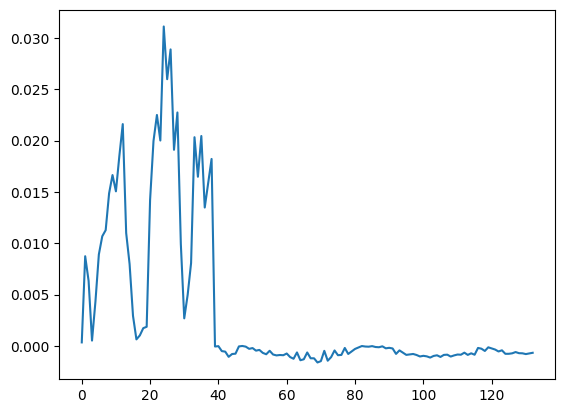

In [23]:
print(type(f.vec))

import matplotlib.pyplot as plt
plt.plot(f.vec.FV().NumPy())

次に左辺の疎行列

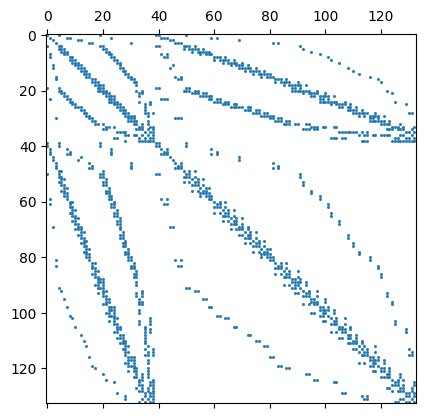

In [24]:
import scipy.sparse as sp

rows,cols,vals = a.mat.COO()
A = sp.csr_matrix((vals,(rows,cols)))

plt.spy(A, markersize=1)
plt.show()

弱形式の方程式を解いて可視化

In [25]:
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

Draw(gfu)

解をベクトルとして可視化

<class 'ngsolve.la.BaseVector'>


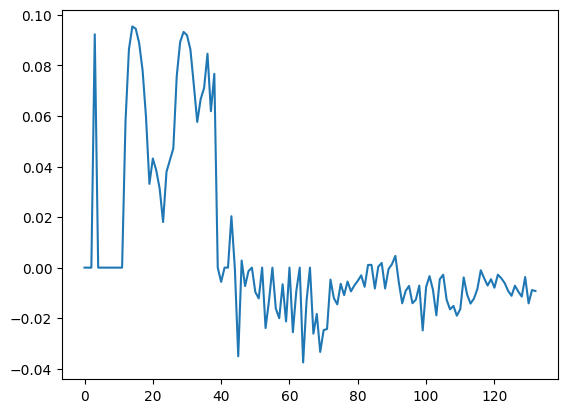

In [26]:
print(type(gfu.vec))
plt.plot(gfu.vec.FV().NumPy())

### 熱方程式

[Parabolic model problem](https://docu.ngsolve.org/latest/i-tutorials/unit-3.1-parabolic/parabolic.html)に従って時間依存性のある偏微分方程式である熱方程式を解く

変数と import をクリア

In [27]:
%reset -f

In [28]:
import ngsolve
from netgen.occ import Rectangle, X, Y, OCCGeometry

shape = Rectangle(2,2).Face().Move((-1,-1,0))
shape.edges.Min(X).name="left"
shape.edges.Max(X).name="right"
shape.edges.Min(Y).name="bottom"
shape.edges.Max(Y).name="top"
mesh = ngsolve.Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.25))

In [29]:
fes = ngsolve.H1(mesh, order=3, dirichlet="bottom|right|left|top")
u,v = fes.TnT()
time = 0.0
dt = 0.001

In [30]:
from ngsolve import x, y
from ngsolve.webgui import Draw

b = ngsolve.CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
Draw(b,mesh,"wind", vectors={"grid_size": 32}, order=3)

In [31]:
from ngsolve import grad, dx

#a = ngsolve.BilinearForm(fes, symmetric=False)
#a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
#a.Assemble()
#m = ngsolve.BilinearForm(fes, symmetric=False)
#m += u*v*dx
#m.Assemble()

a = ngsolve.BilinearForm(0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx).Assemble()
m = ngsolve.BilinearForm(u*v*dx).Assemble()

In [32]:
mstar = m.mat.CreateMatrix()
print(f"m.mat.nze = {m.mat.nze}, a.mat.nze={a.mat.nze}, mstar.nze={mstar.nze}")
print(type(mstar))

m.mat.nze = 11257, a.mat.nze=11257, mstar.nze=11257
<class 'ngsolve.la.SparseMatrixd'>


In [33]:
print(f"mstar.nze={mstar.nze}, len(mstar.AsVector())={len(mstar.AsVector())}")

mstar.nze=11257, len(mstar.AsVector())=11257


In [34]:
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())

In [35]:
f = ngsolve.LinearForm(fes)
gaussp = ngsolve.exp(-6*((x+0.5)*(x+0.5)+y*y))-ngsolve.exp(-6*((x-0.5)*(x-0.5)+y*y))
Draw(gaussp,mesh,"f", deformation=True)
f += gaussp*v*dx
f.Assemble()

In [36]:
gfu = ngsolve.GridFunction(fes)
gfu.Set((1-y*y)*x) # note that boundary conditions remain
scene = Draw(gfu,mesh,"u")

In [37]:
def TimeStepping(invmstar, initial_cond = None, t0 = 0, tend = 2,
                 nsamples = 10):
    if initial_cond:
        gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(ngsolve.floor(tend / dt / nsamples)+1)
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)
    while time < tend - 0.5 * dt:
        res = dt * f.vec - dt * a.mat * gfu.vec
        gfu.vec.data += invmstar * res
        print("\r",time,end="")
        if cnt % sample_int == 0:
            gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [38]:
%%time
gfut = TimeStepping(invmstar, (1-y*y)*x)

 1.999CPU times: user 2.13 s, sys: 167 ms, total: 2.3 s
Wall time: 2.37 s


In [39]:
Draw(gfut, mesh, interpolate_multidim=True, animate=True)